#### Problem Statement

Big Mountain Resort is a ski resort located in Montana. The resort can accommodate skiers and riders of all levels and serves about 350,000 patrons per year. The resort’s pricing strategy has been to charge a premium above the average price of resorts in its market segment. They suspect they are not capitalizing on their facilities. They would like us to help cut costs and potentially set higher ticket prices by understanding how patrons value various facilities. The question we seek to answer is: Which facilities can Big Mountain Resort remove to cut costs and add to maintain or increase ticket price through customer valuation of its facilities by the end of next season?


#### Data Wrangling

The original ski_data had 330 rows and 27 columns. Our resort of interest, Big Mountain Resort, was present in the original data.

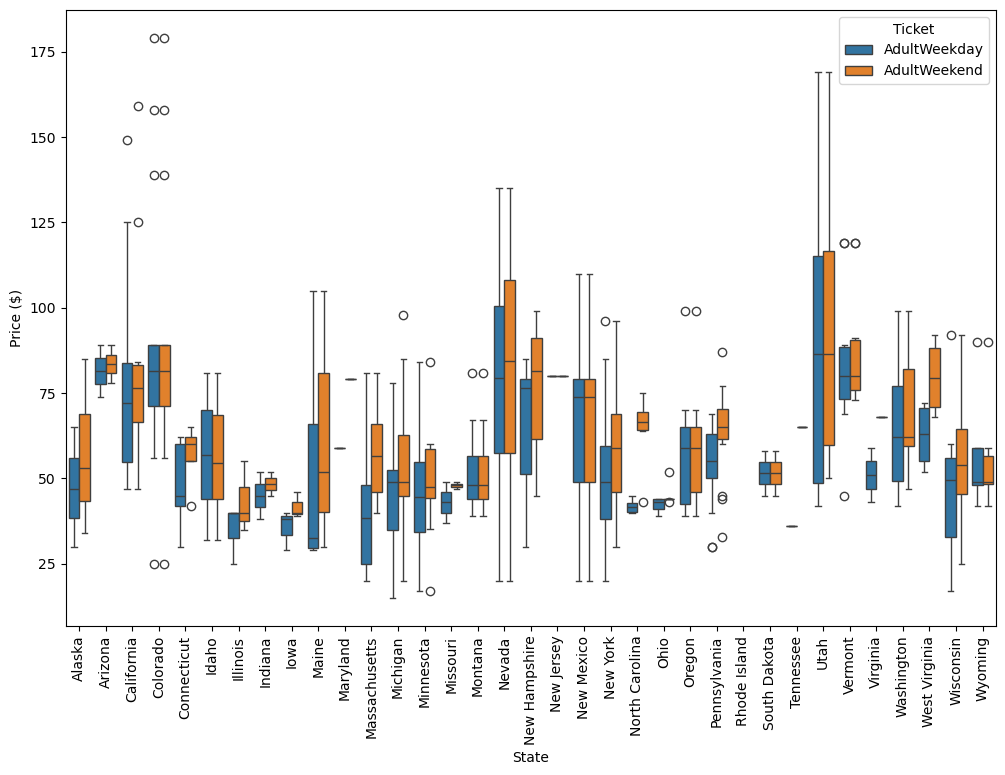

Box plots of ticket price by state showed Montana had relatively low variance between resorts and no difference between weekday and weekend prices.

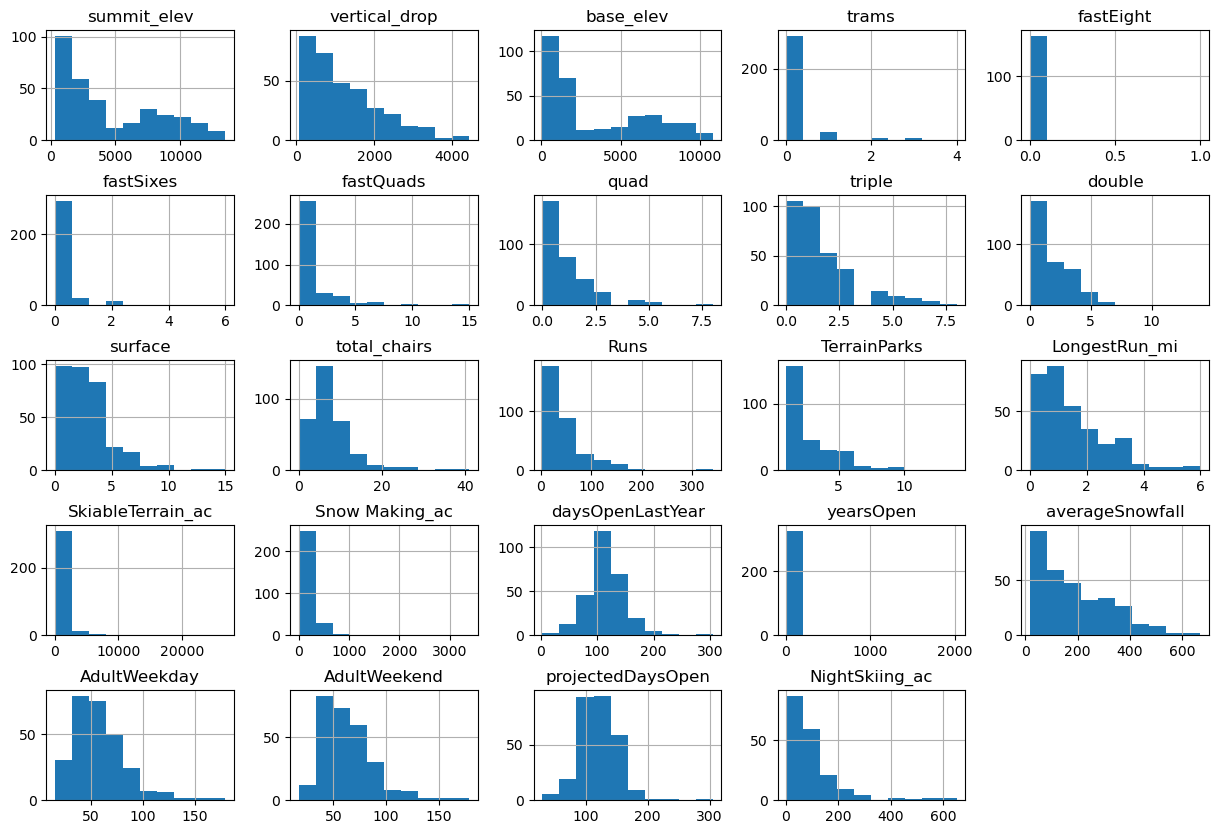

Histograms of the ski_data raised a few concerns. First, the AdultWeekday and AdultWeekend distributions, to name a few, were right-tailed. Skewed data is a sign of outliers, which affects the means and can lead to inaccurate inference or predictions while modeling. Likely taking care of outliers would fix the distributions of most skewed data present in the histograms. The fastEight and fastSixes histograms gave very little information since most of the data was missing or 0. The yearsOpen histogram appeared to have a single cluster near 0 with a maximum value of 2000 - this was likely due to someone inputting a value incorrectly. The fastEight variable was dropped from the dataset because only 1 out of 164 entries were nonzero. Dropping the rows for yearsOpen < 1000 produced a nearly-normal distribution, which is ideal.

The statewide summary was created by grouping the ski_data by state and performing sums down the SkiableTerrain_ac, daysOpenLastYear, TerrainParks, and NightSkiing_ac columns. AdultWeekday and AdultWeekend were the ticket pricing variables of interest. 14% of the data had missing values for both variables, so those rows were dropped from the dataset. Finally, state population and state area data were scraped from wikipedia, a generally reliable website, and merged with the state_summary dataframe.

Because AdultWeekday and AdultWeekend are the same for Montana and AdultWeekend had fewer missing values, I chose to drop AdultWeekday from the dataset and use AdultWeekend as the target pricing variable. After dropping rows with missing values in the AdultWeekend column, the dataset was finally cleaned and ready for EDA.

#### Exploratory Data Analysis

Name, Region, and state were the categorical variables and the remaining were numerical.

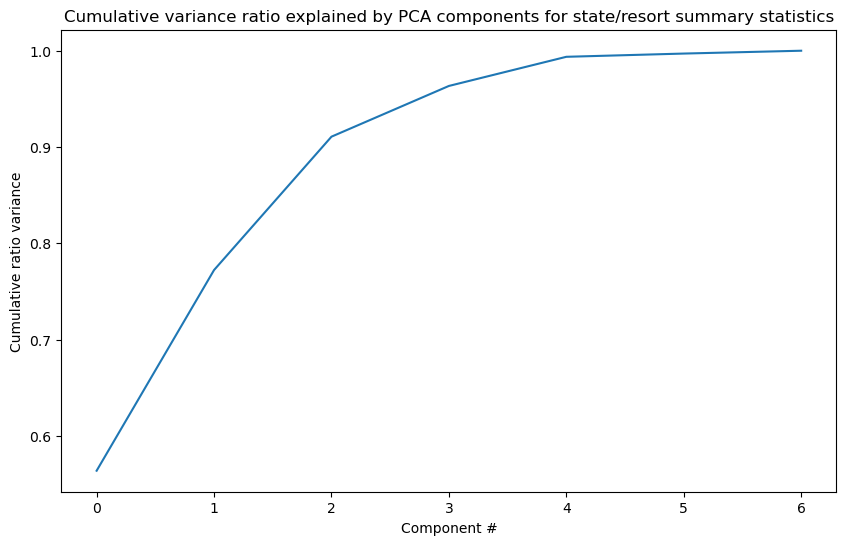

Principle Components Analysis (PCA) can be used to visualize high dimensional data. This is important because humans cannot comprehend what an object looks like beyond the 3rd dimension. PCA allows us to look at relationships between 2 or 3 variables at a time to determine if trends exist and how strong those relationships are. Additionally, PCA can help reduce the complexity of the model by using the smallest combination of variables to explain the largest amount of variance. We can see in the above plot that the first two components acount for over 75% of the variance and the first four components cover 95%.

I created ratio variables for each state by dividing the resorts per state by state population and area, calling them 'resorts_per_100kcapita' and 'resorts_per_100ksq_mile', respectively. Analysis of the PCA components determined those two were the cause for New Hampshire and Vermont to be pushed so high up on the y-axis in the PCA plot. More ratios were calculated using the resort level dataframe to give shares each resort had of the whole state in terms of total skiable area, days open last year, terrain park count, and night skiing area. There did not appear to be a relationship between state and ticket price, so the eventual model can consider all states together and equal.

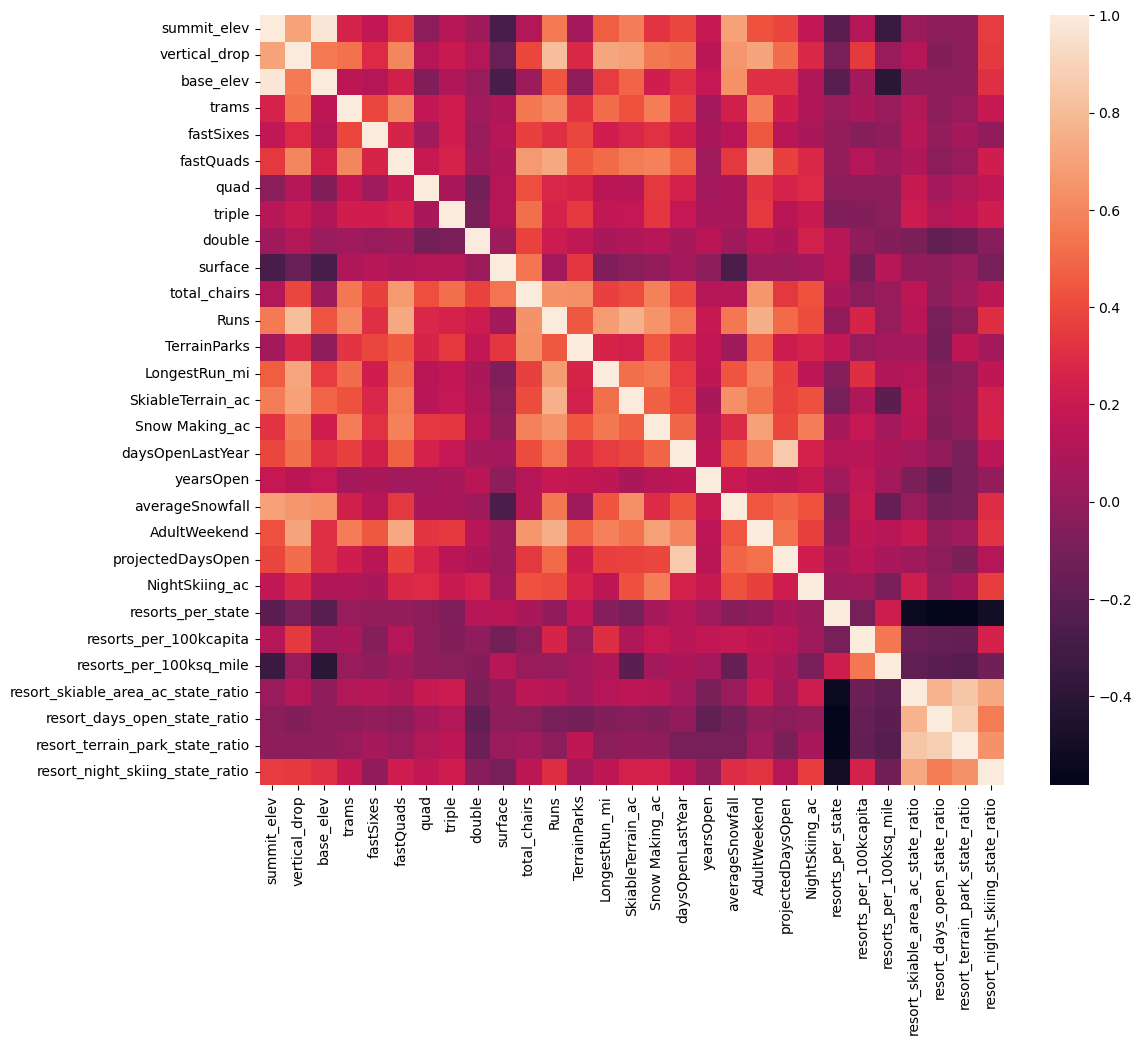

The heatmap of correlation values for all variables in the dataset showed a strong correlation between AdultWeekend (the target price variable) and vertical_drop, fastQuads, Runs, and Snow Making_ac. Some variables with weaker correlations to AdultWeekend that might be considered as features in the model are trams, total_chairs, and TerrainParks. Scatterplots of features by ticket price verify the validity of the aforementioned variables because we see patterns in those plots. Finding features with strong correlations to the outcome variable is fantastic, but we must be wary of multicollinearity. Examining correlations or scatterplots between features of interest can be a great way to discover problematic combinations. If any two features are highly correlated, we ought to consider dropping one from the model.

#### Preprocessing

The first step required splitting the data into training and test sets, making sure to drop non-numeric columns. I used a 70/30 split for this task. Then to get a baseline, I used the mean of ticket price as the assessor for prediction. By definition of SStotal, the result will always be 0. When using the same average as the predictor for the test set, we get a slightly worse (and negative) R^2.

Next, I went through the process of manually calculating R-squared (R^2), mean absolute error (MAE), and mean squared error (MSE), as well as calculating median values and using them to impute missing values. After scaling and transforming the data, I used the LinearRegression function to fit a linear regression model on the training and test setwards.

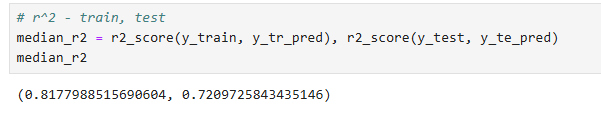

A linear regression model using all available features explained 72.10% of the observed variance in the test set, as measured by R^2.

Then, I incorporated pipelines to simplify the modeling process and added the SelectKBest function to choose a subset of features for the linear regression. I used the default value of 10 and tried k=15, both of which performed worse than using all available features. Rather than continuing to choose arbitrary numbers for k and using the one that performs best on the test set, I incorporated 5-fold cross-validation to avoid the overfitting pitfall; i.e., producing a model that performs well on the test set but is not generalizable to other datasets and will not give reliable predictions. Using CV showed that resulting folds had inherent variability, but still fell within a reasonable range of the estimate without CV.

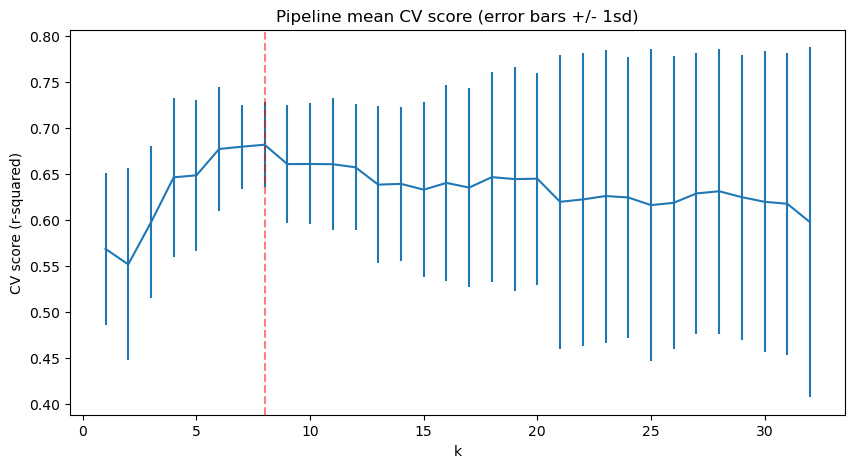

Next, I used the GridSearchCV function on the pipe and parameter grid to find the best k subset of features. The value returned, as seen in the above plot, was 8. Inspecting the coef_ attribute of the linear regression object, I returned a Pandas series of the feature names and their corresponding beta values.

Finally, I used a similar pipeline, but with the RandomForestRegressor function to perform a random forest instead of linear regression model. Not many hyperparameters were explored, but values were imputed with both mean and median, and GridSearchCV was used with 5-fold CV. The results showed using median instead of mean without scaling the features produced the best results.

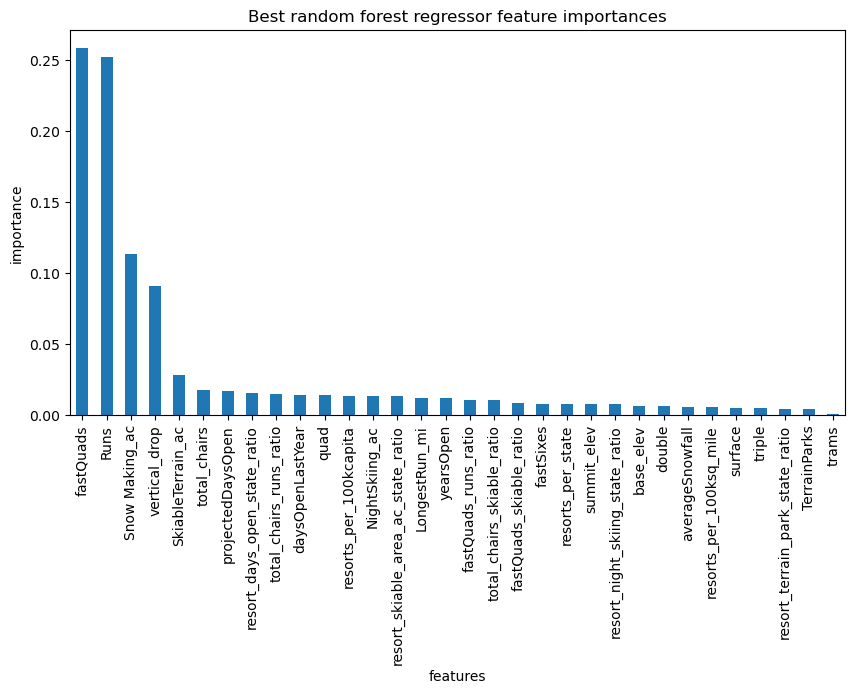

The above plot shows that fastQuads, Runs, and Snow Making_ac were the best predictor variables in the random forest model.

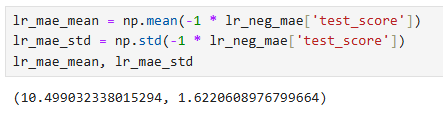 <br>
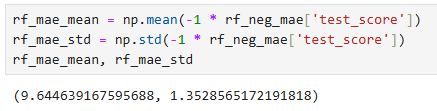

Lastly, comparing the results of the linear regression with the random forest model, we can see that the random forest had a lower cross-validation MAE and lower variance. Test set performance also verified the random forest model to be superior. Therefore, the random forest model is the clear winner.

#### Modeling

Big Mountain Resort currently charges \\$81 per adult ticket. The fitted model suggests a price of \\$95.87. Accounting for the mean absolute error of \\$10.39, this still suggests ~\$4.50 increase in ticket price.

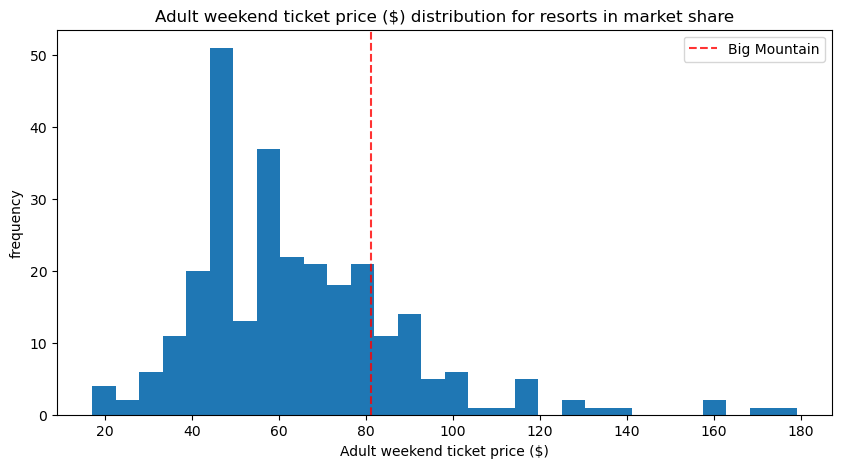 <br>
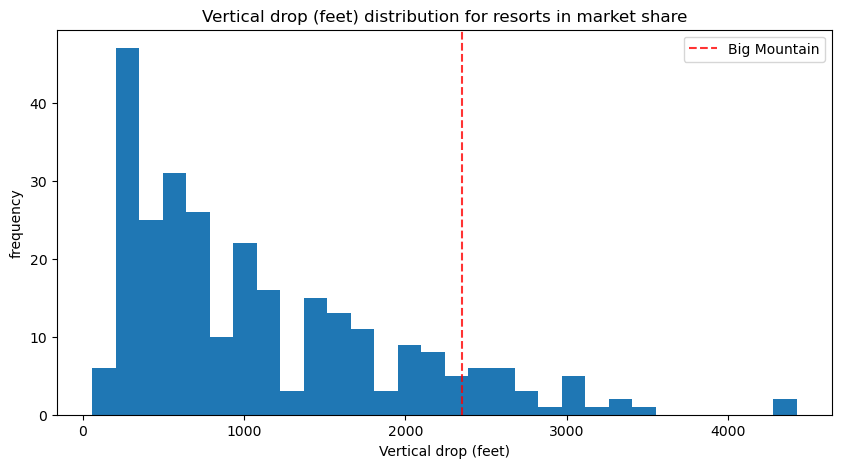 <br>
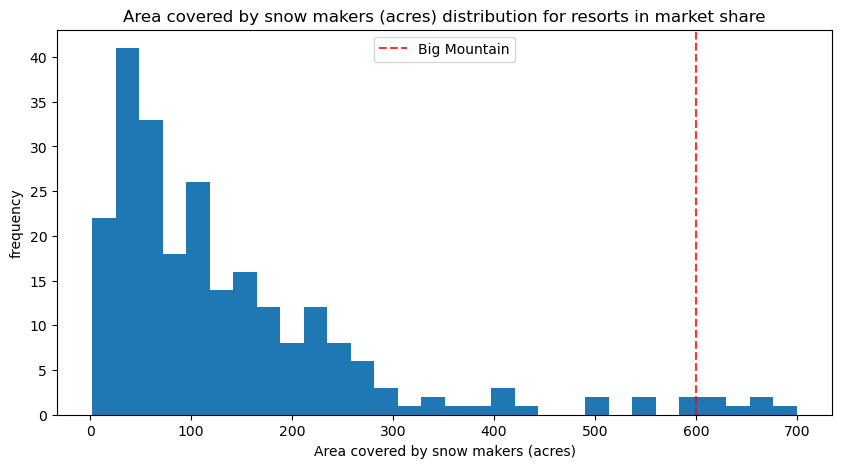 <br>
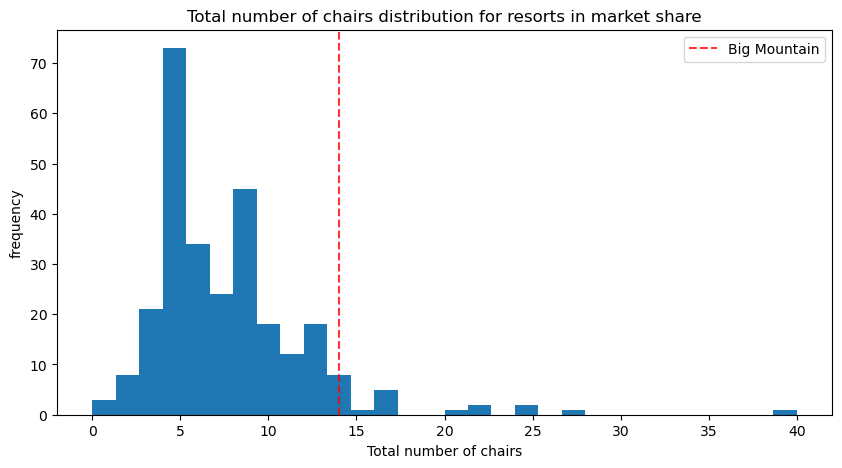 <br>
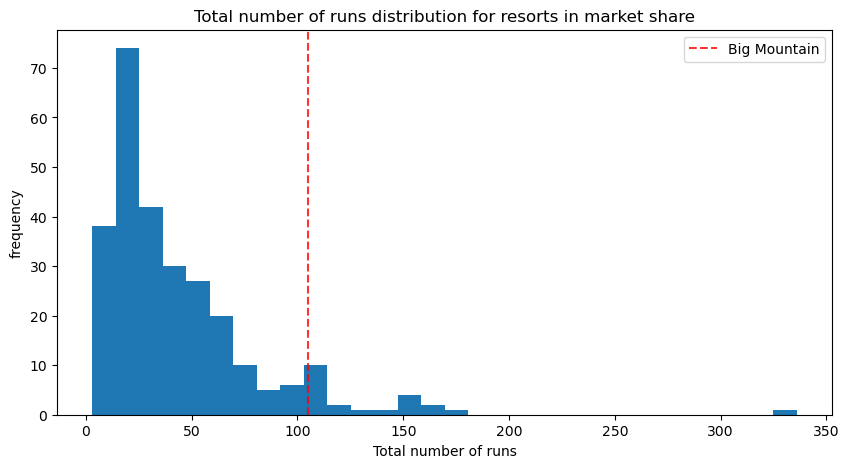 <br>
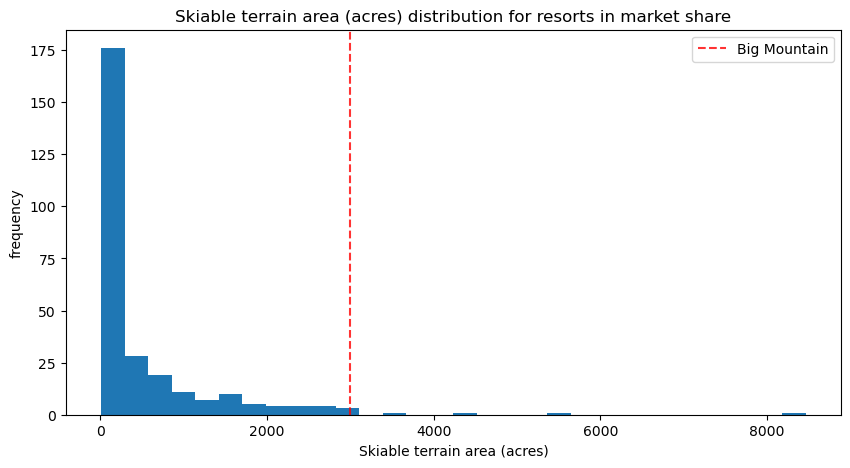

Histograms of important features showed that Big Mountain fell on the upper end of all distributions and could justify an increase in price. Out of the 4 modeling scenarios, scenario 2 - adding a run, increasing the drop by 150 feet, and installing an additional chair lift - seemed like the most worthwhile venture and justified an increase in price of \\$1.99. Scenario 3 was identical to scenario 2, but involved adding an additional 2 acres of snow making. The additional effort added no monetary benefit, so we should prefer scenario 2. Scenario 4 did not justify increasing price.

Scenario 1 requires more information to consider because we need to know operating costs of runs to appropriately suggest what ought to be done. Assuming the operating costs of runs are independent of one another, we could close 1 run to cut costs without affecting ticket price according to the model, thus resulting in higher net revenue. For additional closures, we must justify a decrease in ticket price. For example, assuming 350,000 guests each buying 5 day passes at the current price of \\$81, we get \\$141,750,000 revenue for the season. Closing down 5 runs would require a decrease in ticket price of ~\\$0.70, which amounts to a decrease in revenue by \\$1,225,000. If the operating costs of the 5 chosen runs exceeds \\$1.225 million per season, we can recommend closing the runs.

Similarly, we can consider covering the cost of the new chair lift by adjusting ticket price. At a cost of \\$1.54 million per season, ticket price would need to increase by \\$0.88 to cover the cost of the lift. If we go with increasing price by \\$1.99 as model 2 suggests, we can simply reduce the amount by \\$0.88 arriving at an overall increase of \\$1.11 per ticket.

It's important to note that while the overall model (accounting for MAE variation) suggested an increase of ~\\$4.50, we should not simply increase ticket prices by that amount. We must model different scenarios and verify which adjustments should be made and how much those changes affect the price if we want to make smart, data-driven business decisions.

#### Further Scope of Work

The main deficiency of the dataset is having no cost data. Operational costs of all aspects of the resorts (runs, employee salary, electricity, etc.) would greatly improve the robustness of the model. The mismatch in current price vs. modeled price certainly seems shocking at face value, but Big Mountain seemed to have a hunch their pricing was inefficient already; this is why I was brought in as part of the data science team to suggest a better pricing model instead of one based purely on market average.

Assuming the business leaders felt this model was useful, they could go with my suggestions and implement a ticket price increase of \\$1.11 and may even be able to cut costs by closing down a few runs, understanding that \\$1.11 amount would decrease as more runs are shut down.

This model could be made available for other analysts to explore by creating an executable file using a tool like PyInstaller. This would allow others to run the program without seeing or modifying the source code. I could envision putting pipelines inside custom functions that users could call and supply parameters to. to.